### Clean data to be used for all simulations

#### Import modules and function to be use

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib, sys
import seaborn as sbn

In [2]:
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

from oriFunctions import excel_folder, readAndReshape_excelFile

### Work on HT Producers

In [3]:
#Load files
file_p_inj_0013 = 'Prod_HTA/PROD_Bis/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/PROD_Bis/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'

# The  commissioning of the Prod P0100 is recent (2022). I therefore use the data of the closer energy 
# producer that is P0058  and consider it as that of Prod P0100 
file_p_inj_0100 = 'Prod_HTA/PROD_Bis/PROD-SERGIES 2204 (LA ROCHE A CORNUCHON)-PINDRAY - Actif P-.csv'

# Get files data 
p_mw_0013 = readAndReshape_excelFile(file_p_inj_0013 ,excel_folder, )
p_mw_0018 = readAndReshape_excelFile(file_p_inj_0018 ,excel_folder,)
p_mw_0100 = readAndReshape_excelFile(file_p_inj_0100 ,excel_folder,)

# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013[:len(p_mw_0100)], 
                'P0018': p_mw_0018[:len(p_mw_0100)],
                'P0100': p_mw_0100[:len(p_mw_0100)]
               }

# Create index to use for dataframe
# The first day in the excel file is 01 01 2020
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0100), freq='10T')

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)


#### Plot Data

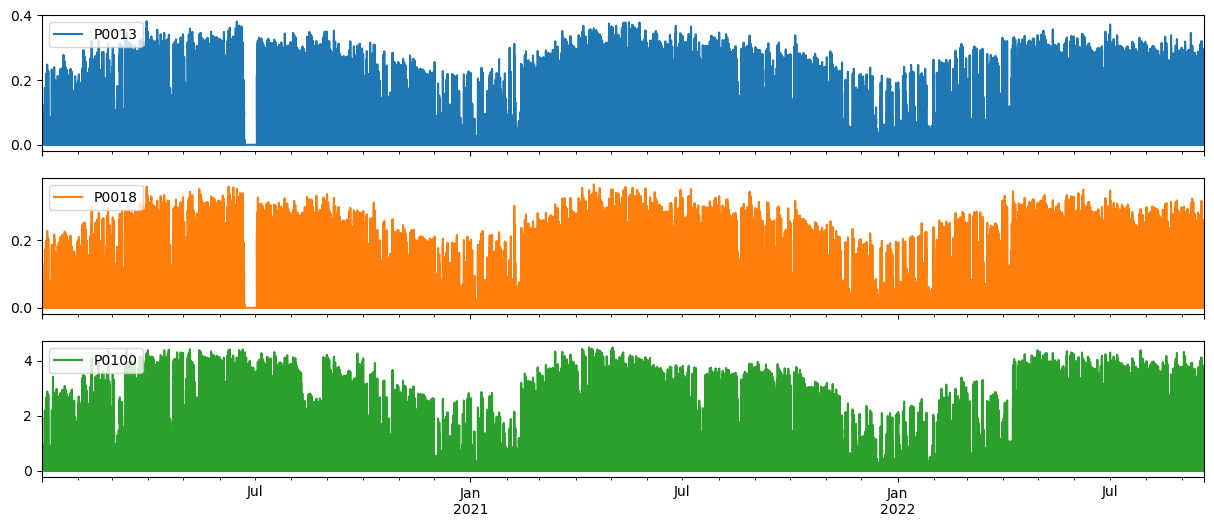

In [4]:
df_prodHT.plot(subplots=True, figsize=(15,6));

#### Replace missing data for P0013 and P0018

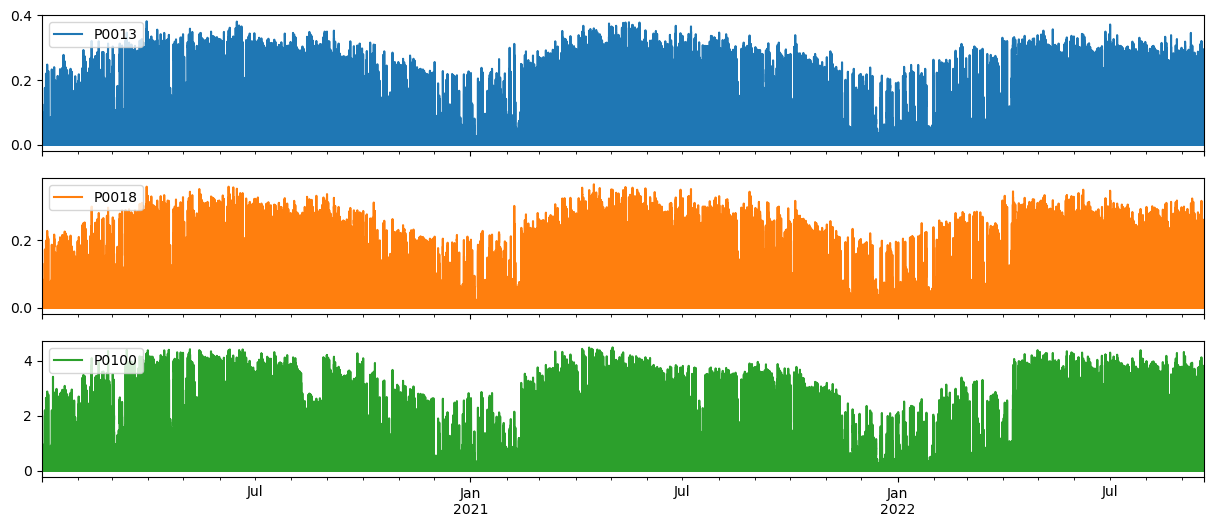

In [5]:
# Replacing missing data by the mean of surrondings periods
# Extract previous and following days 
previous_days = df_prodHT.loc[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50'),['P0013','P0018']]
following_days = df_prodHT.loc[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50'),['P0013','P0018']]

# Put the interpolated data into the initial dataframe
df_prodHT.loc[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50'), ['P0013','P0018']] = (np.array(following_days) +
                                                                                                 np.array(previous_days) )/2
# Plot to check if everything is ok
df_prodHT.plot(subplots=True, figsize=(15,6));

### Work on Consumption

In [6]:
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'
p_mw_cons_total = readAndReshape_excelFile(file_cons_total, excel_folder)

# Dataframe Conso BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_cons_total), freq='10T')
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index, columns=['Cons'])


#### Plot Data

<AxesSubplot:>

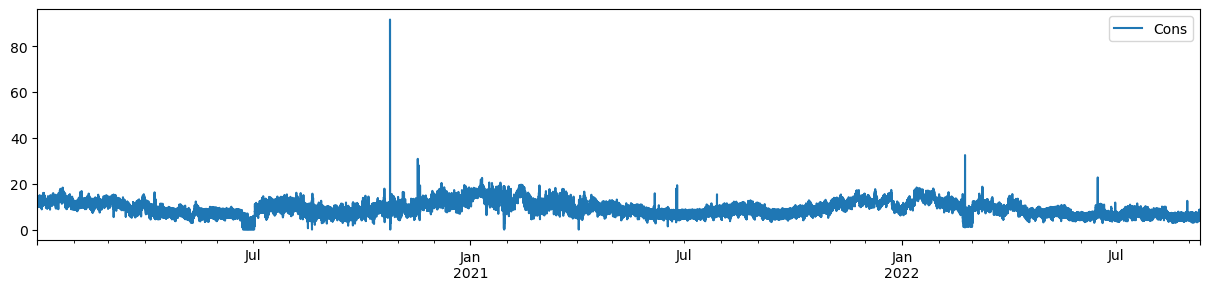

In [7]:
df_cons_total.plot(figsize=(15,3))

#### Remove pic from data 

<AxesSubplot:>

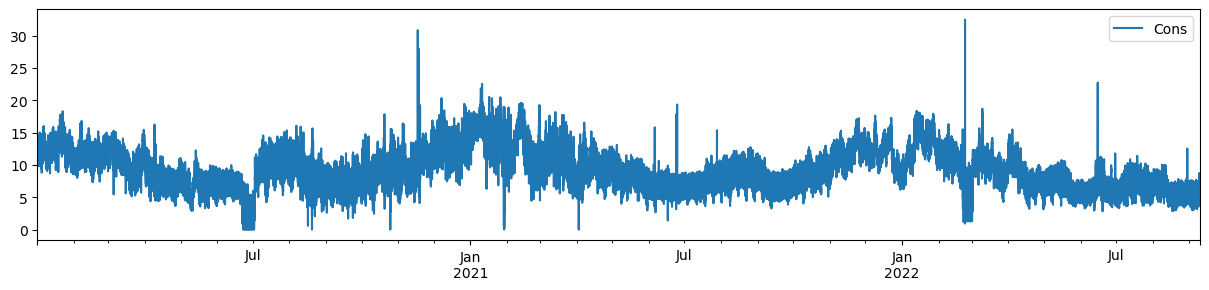

In [8]:
max_indx = df_cons_total.Cons.argmax()  # Get the indice of the period where the pic occurs
# replace the value with the mean of the previous and following periods
df_cons_total.Cons[max_indx] = (df_cons_total.Cons[max_indx-1] + df_cons_total.Cons[max_indx-1])/2
df_cons_total.plot(figsize=(15,3))

#### zoom on periods where data ins unavailable

[(27421920.0, 27440640.0)]

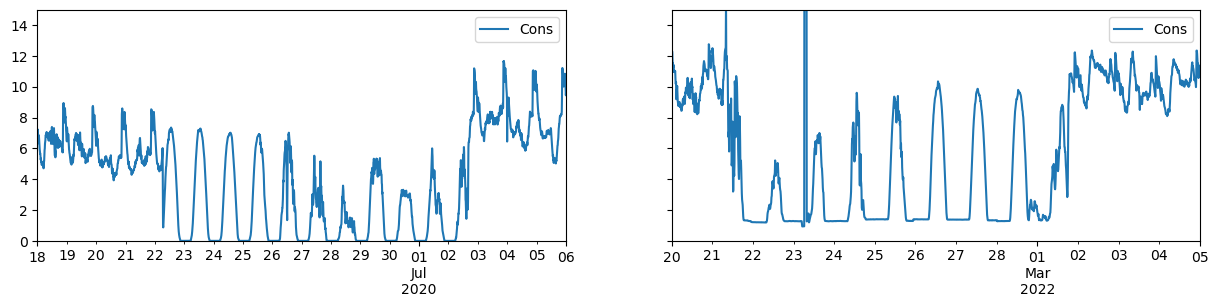

In [9]:
fig, axx = plt.subplots(1,2, figsize=(15,3), sharey=True)
df_cons_total.plot(ax=axx[0])
axx[0].set(xlim = ('2020 06 18', '2020 07 06'),
           ylim=(0,15))

df_cons_total.plot(ax=axx[1])
axx[1].set(xlim = ('2022 02 20', '2022 03 05'),
           )
# fig.tight_layout()

#### Replace periods where data is PV production like by mean of preceding and following periods

<AxesSubplot:>

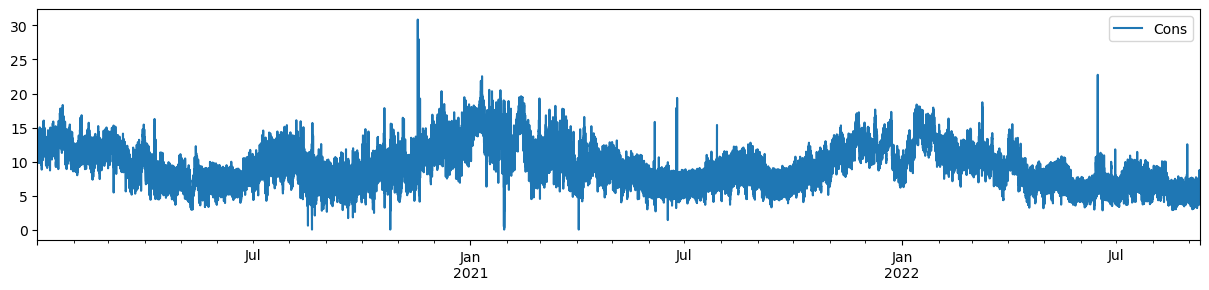

In [10]:
#First period '2020 06 22' to '2020 07 02
previous_days = df_cons_total[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50')]
following_days = df_cons_total[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50')]
# Put the interpolated data into the dataframe
df_cons_total[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2

#Second period '2022 02 21' to '2022 03 02'
previous_days = df_cons_total[(per_index>='2022 02 11') & (per_index<='2022 02 20 23:50')]
following_days = df_cons_total[(per_index>='2022 03 03') & (per_index<='2022 03 12 23:50')]
# Put the interpolated data into the dataframe
df_cons_total[(per_index>='2022 02 21') & (per_index<='2022 03 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2
df_cons_total.plot(figsize=(15,3))


#### Outlier detection
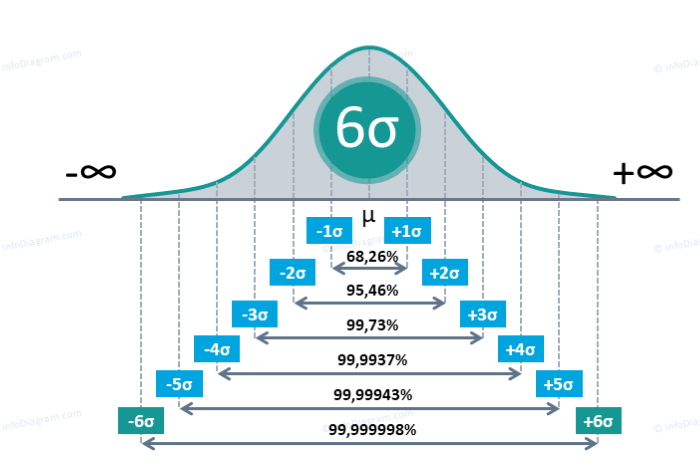

In [11]:
copy_df_cons_total = df_cons_total.copy(deep=True)
# copy_df_cons_total['year'] = copy_df_cons_total.index.year
copy_df_cons_total['month'] = copy_df_cons_total.index.month# Add some column to the copy dataframe

n_std = 4
mean_values = copy_df_cons_total.groupby('month').mean()
low_bound_value = mean_values - (n_std)*copy_df_cons_total.groupby('month').std()
high_bound_value = mean_values + (n_std)*copy_df_cons_total.groupby('month').std()

lower_bound_df = pd.DataFrame(index=copy_df_cons_total.index, columns=['Lower Bound'])
mean_df = pd.DataFrame(index=copy_df_cons_total.index, columns=['Mean'])
higher_bound_df = pd.DataFrame(index=copy_df_cons_total.index, columns=['Higher Bound'])

for cur_month in range(1,13):
    lower_bound_df[lower_bound_df.index.month==cur_month] = low_bound_value.loc[cur_month, 'Cons']    
    higher_bound_df[higher_bound_df.index.month==cur_month] = high_bound_value.loc[cur_month, 'Cons'] 
    mean_df[mean_df.index.month==cur_month] = mean_values.loc[cur_month, 'Cons']

<AxesSubplot:>

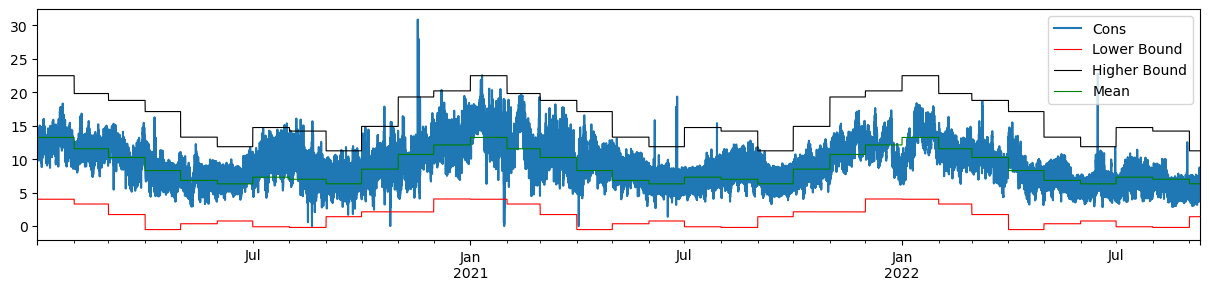

In [12]:
fig, axx = plt.subplots(figsize=(15,3))
df_cons_total.plot(ax=axx)
lower_bound_df.plot(c='r',ax=axx, lw=0.8)
higher_bound_df.plot(c='k', ax=axx, lw=0.8)
mean_df.plot(c='g', ax=axx, lw=0.8)

<AxesSubplot:>

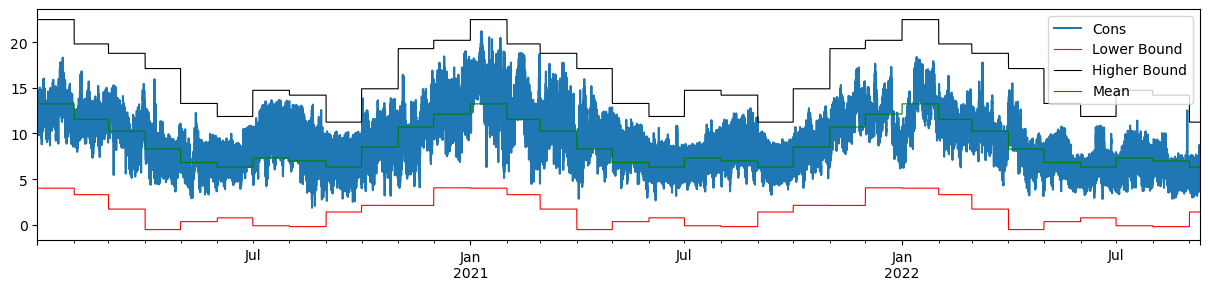

In [16]:
leaway = 1
high_mask = copy_df_cons_total['Cons'].values >= higher_bound_df['Higher Bound'].values-leaway
low_mask = copy_df_cons_total['Cons'].values <= lower_bound_df['Lower Bound'].values + leaway

copy_df_cons_total.loc[:,'Cons'][high_mask] = mean_df.iloc[:,0][high_mask].values
copy_df_cons_total.loc[:,'Cons'][low_mask] = mean_df.iloc[:,0][low_mask].values


fig, axx = plt.subplots(figsize=(15,3))
copy_df_cons_total[['Cons']].plot(ax=axx)
lower_bound_df.plot(c='r',ax=axx, lw=0.8)
higher_bound_df.plot(c='k', ax=axx, lw=0.8)
mean_df.plot(c='g', ax=axx, lw=0.8)

#### Assumption1 : The consumption at any instant should not be lower than 2Mw

Replace all the periods where the consumption is lower than 2 by the mean of consumption data

<AxesSubplot:>

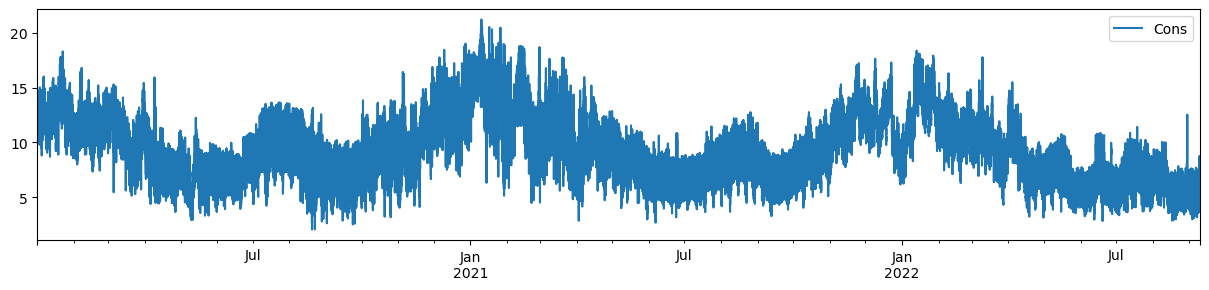

In [14]:
copy_df_cons_total.drop(columns='month', inplace=True)   
df_cons_total = copy_df_cons_total.copy(deep=True)

df_cons_total.Cons[df_cons_total.Cons<=2]=df_cons_total.Cons.mean()
df_cons_total.plot(figsize=(15,3))

### Work on Prod BT

<AxesSubplot:>

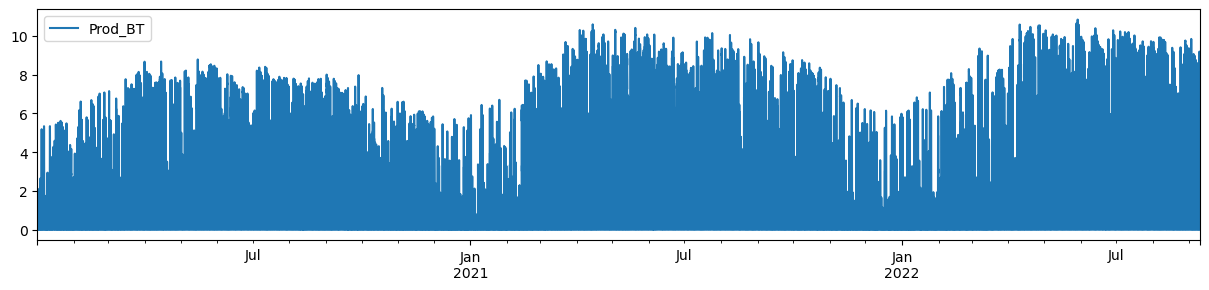

In [15]:
file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
p_mw_prod_bt_total = readAndReshape_excelFile(file_prod_bt_total, excel_folder)

# Dataframe prod BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_prod_bt_total), freq='10T')
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])

df_prod_bt_total.plot(figsize=(15,3))

### Save df_data


In [34]:
joblib.dump(df_data.dropna(), 'pickle_files/cleanedData.pkl')

['pickle_files/cleanedData.pkl']